# **CTR Prediction** 
#### Click-through-rate is always a key metric for companies to evaluate the effectiveness of advertising. This project uses Logistic Regression, XGboost, and LightGBM to predict whether the user with particular sets of features will click the advertisement or not.

## **Part 0: Import package & Read Data**

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs
import sklearn
import matplotlib.dates as mdates
matplotlib.style.use('ggplot')

In [5]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
import pandas as pd 
from datetime import datetime

id = "1pS232a18H5CkcqwyTwu_TGB9e0PLYkcF"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('train.csv')
train_data = pd.read_csv('train.csv')

In [7]:
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2.541190e+18,0,14102809,1005,0,85f751fd,c4e18dd6,50e219e0,f53417e1,0e8616ad,...,1,2,23143,320,50,2665,0,34,-1,221
1,1.262366e+19,1,14102205,1002,0,85f751fd,c4e18dd6,50e219e0,c73fb408,7801e8d9,...,0,0,21778,320,50,2503,2,35,-1,90
2,3.258308e+18,0,14102410,1005,0,f58d0bc8,7e3be6ba,f028772b,ecad2386,7801e8d9,...,1,0,17239,320,50,1973,3,39,100148,23
3,6.931321e+18,0,14102208,1005,0,5bcf81a2,9d54950b,f028772b,ecad2386,7801e8d9,...,1,0,21767,320,50,2506,0,35,100111,157
4,1.634653e+19,0,14103010,1005,0,6399eda6,968765cd,f028772b,ecad2386,7801e8d9,...,1,2,19950,320,50,1800,3,167,100075,23


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                404290 non-null  float64
 1   click             404290 non-null  int64  
 2   hour              404290 non-null  int64  
 3   C1                404290 non-null  int64  
 4   banner_pos        404290 non-null  int64  
 5   site_id           404290 non-null  object 
 6   site_domain       404290 non-null  object 
 7   site_category     404290 non-null  object 
 8   app_id            404290 non-null  object 
 9   app_domain        404290 non-null  object 
 10  app_category      404290 non-null  object 
 11  device_id         404290 non-null  object 
 12  device_ip         404290 non-null  object 
 13  device_model      404290 non-null  object 
 14  device_type       404290 non-null  int64  
 15  device_conn_type  404290 non-null  int64  
 16  C14               40

In [9]:
train_data.shape

(404290, 24)

In [10]:
#check non_values 
train_data.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [11]:
#check unique value of the click
train_data.click.value_counts() 

0    335649
1     68641
Name: click, dtype: int64

## **Part 1: EDA**

0    0.830218
1    0.169782
Name: click, dtype: float64

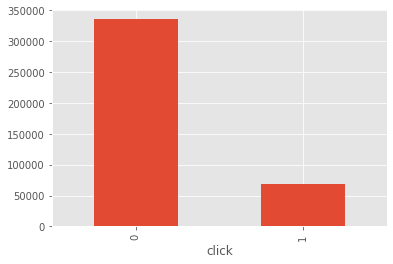

In [12]:
# Click v/s No click distribution
train_data.groupby('click').size().plot(kind = 'bar')
rows = train_data.shape[0]
click_through_rate = train_data['click'].value_counts()/rows 
click_through_rate

In [13]:
train_data['hour'].describe() 

count    4.042900e+05
mean     1.410256e+07
std      2.966960e+02
min      1.410210e+07
25%      1.410230e+07
50%      1.410260e+07
75%      1.410281e+07
max      1.410302e+07
Name: hour, dtype: float64

In [14]:
# banner position
"""Banner positions representing attractive and appealing designs that might highly 
affect a user's behavior and in turn trigger their decision to click. Or not. 
Hence making it an effective metric to predict clicks"""
train_data['banner_pos'].unique()

array([0, 1, 2, 7, 4, 3, 5])

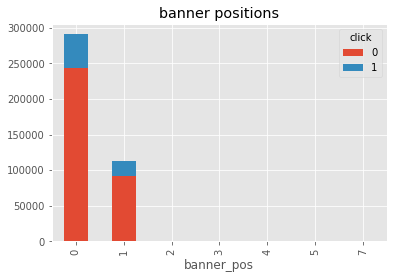

In [15]:
# banner position & click relation
banner_temp =train_data[['banner_pos','click']].groupby(['banner_pos','click'])

banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

In [16]:
train_data[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,290807
1,112754
7,425
2,143
4,82
5,59
3,20


In [17]:
# click percent for each banner position
train_data_clicks = train_data[train_data['click']==1]
banner_df = pd.DataFrame()
banner_df['position'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['banner_pos']
banner_df['pos_clicks'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']
banner_df['total_impressions'] = train_data[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click'] #全部点击
banner_df['click_pct'] = 100*banner_df['pos_clicks']/banner_df['total_impressions']
banner_df

,position,pos_clicks,total_impressions,click_pct
0,0,47692,290807,16.399880
1,1,20769,112754,18.419746
6,7,135,425,31.764706
2,2,19,143,13.286713
4,4,16,82,19.512195
5,5,7,59,11.864407
3,3,3,20,15.000000


In [18]:
banner_df.sort_values(ascending=False,by='click_pct') #We find position 7 has best ctr while there are not many people click it

,position,pos_clicks,total_impressions,click_pct
6,7,135,425,31.764706
4,4,16,82,19.512195
1,1,20769,112754,18.419746
0,0,47692,290807,16.399880
3,3,3,20,15.000000
2,2,19,143,13.286713
5,5,7,59,11.864407


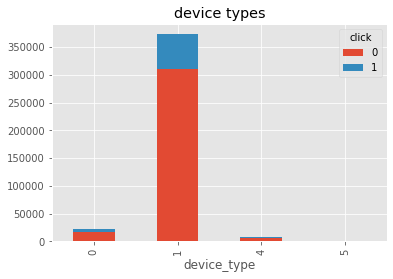

In [19]:
# Device type & click relation
device_temp = train_data[['device_type','click']].groupby(['device_type','click'])
device_temp.size().unstack().plot(kind='bar',stacked=True, title='device types')

In [20]:
train_data[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,373036
0,22138
4,7876
5,1240


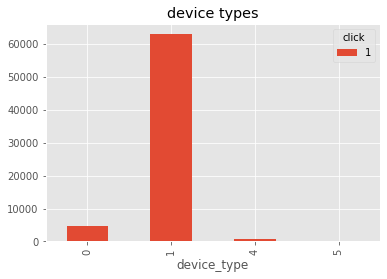

In [21]:
train_data_clicks[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device types')

In [22]:
# click percent for each device type
dev_type_df = train_data_clicks.groupby('device_type').agg({'click':'sum'}).reset_index()
dev_type_df_total_imp = train_data.groupby('device_type').agg({'click':'count'}).reset_index()
dev_type_df['total_impressions'] = dev_type_df_total_imp['click']
dev_type_df['success_pct'] = (dev_type_df['click']/dev_type_df['total_impressions'])*100
dev_type_df

,device_type,click,total_impressions,success_pct
0,0,4684,22138,21.158190
1,1,63027,373036,16.895688
2,4,813,7876,10.322499
3,5,117,1240,9.435484


In [23]:
# App category and click relation
app_features = ['app_id', 'app_domain', 'app_category']
train_data.groupby('app_category').agg({'click':'sum'}).sort_values(by='click',ascending = False)

,click
app_category,
07d7df22,52025
0f2161f8,10385
f95efa07,2876
cef3e649,1657
8ded1f7a,1229
d1327cf5,154
dc97ec06,94
09481d60,86
75d80bbe,41


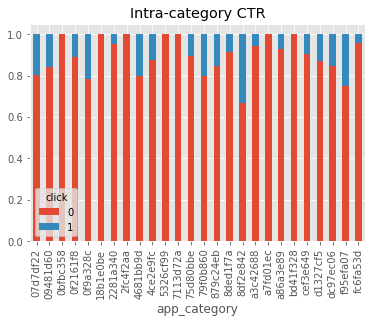

In [24]:
# Clicks behavior across different app categories
train_app_category = train_data.groupby(['app_category', 'click']).size().unstack()
train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

In [25]:
# C1, C14-C21 features
features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18',
            'C20', 'C21']
train_data[features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C20,C21
count,404290,404290,404290,404290,404290,404290,404290,404290
unique,7,2070,8,9,414,4,158,60
top,1005,4687,320,50,1722,0,-1,23
freq,371380,9377,377187,381520,44987,168957,189623,89239


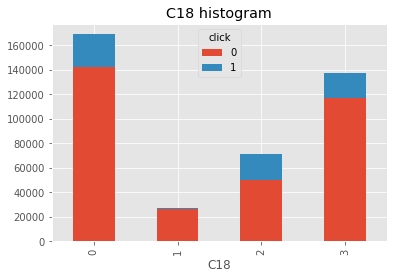

In [26]:
# train_data.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
# train_data.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
# train_data.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 histogram')

## **Part 2: Data Pre-processing**


In [27]:
# select features
model_features = ['banner_pos', 'site_category', 'device_conn_type', 'app_category','device_type', 'C14', 'C17']
model_target = 'click'
train_model = train_data[model_features+[model_target]]
train_model.shape

(404290, 8)

In [28]:
# categorical feature encoding
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                    columns = feature_set,
                                    sparse = True)

    return new_data_frame

In [29]:
train_model = one_hot_features(train_model,
                                ['site_category',
                                 'app_category',
                                 'banner_pos'])

In [30]:
train_model.head(3)

,device_conn_type,device_type,C14,C17,click,site_category_0569f928,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_42a36e14,...,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7
0,2,1,23143,2665,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,21778,2503,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,17239,1973,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [31]:
train_x = train_model.drop('click', axis=1)
train_y = train_model[['click']]

## **Part 3: Model Training and Result Evaluation**


In [32]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    train_x.values,
    train_y.values.ravel(),
    stratify=train_y.values,
    test_size=0.3
)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# helper function for printing out grid search results (for future uses)
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

## Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

parameters = {
     'penalty':('l2','l1'), 
     'C':(0.142,0.143,0.145,0.147,0.149), #Inverse of regularization strength; must be a positive float. 
                                    #smaller values specify stronger regularization.
}

Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear', max_iter = 200),parameters, cv=5) 
#Using k-fold validation -- calculate performance for each skeleton 5 times and calculate the average performance
# solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’
# For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
#For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
Grid_LR.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=200, solver='liblinear'),
             param_grid={'C': (0.142, 0.143, 0.145, 0.147, 0.149),
                         'penalty': ('l2', 'l1')})

In [35]:
# best Logistic Regression model
best_LR_model = Grid_LR.best_estimator_
best_LR_model

LogisticRegression(C=0.142, max_iter=200, penalty='l1', solver='liblinear')

## XGboost

In [ ]:
from xgboost import XGBClassifier

parameters = {
    'learning_rate':[0.2,0.25], #defualt 0.3
    'n_estimators':[100], #num of tree we build for each round, default is 100
    'max_depth':[10,12,14],
    'subsample':[1], #each tree takes x% of total sample
    'colsample_bytree':[1], # each tree see x% total features 
    'lambda':[1],
    'gamma':[0],
    'min_child_weight': [0], #cover value, default is 1, for classification, cover can be less than 1, 
                             #so this value should change to 0 to prevent no value present in the leave
    'objectve': ['binary:logistic'], # 'multi:softprob' for multicalss, 
                                    #'reg:squarederror' for regression and it is also the default value
}

Grid_XGboost = GridSearchCV(XGBClassifier(),parameters, cv=5) #cv = 5 5-fold cross validation
Grid_XGboost.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="logloss", eval_set=[(x_test, y_test)]) #early_stopping_rounds: overfitting prevention, 
                                                                #stop early if no improvement in learning
print_grid_search_metrics(Grid_XGboost)                                              

In [37]:
# best XGboost model
best_XGboost_model = Grid_XGboost.best_estimator_
best_XGboost_model

XGBClassifier(lambda=1, learning_rate=0.25, max_depth=10, min_child_weight=0,
              objectve='binary:logistic')

## LightGBM

In [ ]:
import lightgbm as lgb 
from lightgbm import LGBMClassifier

parameters = {
    'learning_rate':[0.13,0.15,0.17], #default is 0.1
    'num_iterations':[100], #num of tree we build for each round, default is 100
    'max_depth':[10,12,14],
    'num_leaves':[31,35], #default is 31, max number of leaves in one tree
    'subsample':[0.8,1], #each tree takes x% of total sample
    'feature_fraction':[0.8,1], # each tree see x% total features 
    'lambda_l2':[0], #default is 0
    'lambda_l1':[0], #default is 0
    'objectve': ['binary'], # Default: ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
    'max_bin': [255], # default = 255, max number of bins the feature value will be bucketed in (histogram based grouping!)
}

Grid_LightGBM = GridSearchCV(LGBMClassifier(),parameters, cv=5) #cv = 5 5-fold cross validation
Grid_LightGBM.fit(x_train,y_train,eval_set=[(x_test,y_test)],
          verbose=20,eval_metric='logloss') #verbose是什么? 

print_grid_search_metrics(Grid_LightGBM) 

In [42]:
# best LightGBM model
best_LightGBM_model = Grid_LightGBM.best_estimator_
best_LightGBM_model

LGBMClassifier(feature_fraction=1, lambda_l1=0, lambda_l2=0, learning_rate=0.17,
               max_bin=255, max_depth=10, num_iterations=100, num_leaves=35,
               objectve='binary', subsample=0.8)

## Evaluate the 3 model

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print ("f1-score is: " + str(2/(1/precision + 1/recall)))
    print ()

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(x_test))),
    ("XGboost", confusion_matrix(y_test,best_XGboost_model.predict(x_test))),
    ("LightGBM", confusion_matrix(y_test, best_LightGBM_model.predict(x_test)))
]

draw_confusion_matrices(confusion_matrices) 

Logistic Regression
Accuracy is: 0.8304105139050352
precision is: 0.6825396825396826
recall is: 0.002088189588189588
f1-score is: 0.0041636407649479545

XGboost
Accuracy is: 0.8323068424480777
precision is: 0.5707098937954165
recall is: 0.04958236208236208
f1-score is: 0.09123810374871542

LightGBM
Accuracy is: 0.8325129651157998
precision is: 0.6144975288303131
recall is: 0.036227661227661224
f1-score is: 0.06842153535724112



# Results
Base on the results, I find that XGboost and Lightgbm model perfomence better than Logistic Regression as LR model has a low recall score. For XGboost and Lightgbm, they both have particular advantages.
# compare Lightgbm and XGboost
For speed, assuming both model run 100 iterations per model. Lightgbm grid search has 72 different combinations of hyperparameters and training time was 11 mins while XGboost only has 6 combinations and training time was 32 mins. On average, for 100 iterations, Lightgbm need 0.15 min for each model while XGboost need 5.3 min for each model. LightGBM is 35 times faster than the XGboost! 

### Lightgbm: has a faster training speed but lower f1-score
### XGboost: has a slower training speed but higher f1-score


